# Problem #2

## Data Ingest and Formatting

In [53]:
# Common Imports
import csv
import pathlib
import itertools
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle
from prettytable import PrettyTable


# Ensure the plot output directory exists
pathlib.Path('./out').mkdir(parents=True, exist_ok=True)

# Read in the data from excel file
kicks = pd.read_excel('./data/Penalty_kick.xlsx',sheet_name='Sheet1')
kicks.columns = ['x', 'y', 'z', 'area']
Areas = [x for x in range(1, 7)]

print(kicks.head())

# Create a dictionary to store the number of kicks in each area
area_counts = dict()
for area in Areas:
    area_counts[area] = kicks[kicks['area'] == area].shape[0]

# Helpful other config
hallow_marker = dict(marker='o', markersize=3,
                           color='black',
                           markerfillstyle='none')

   x         y         z  area
0  0  0.473291  2.588263     6
1  0 -0.011907  1.378378     6
2  0  0.779689  2.070065     5
3  0  0.522825  1.618830     6
4  0  0.454070  2.212465     6


## Probability Profile for each Area
Note: `Y` is viewed as horizontal Axis and `Z` is viewed as vertical Axis

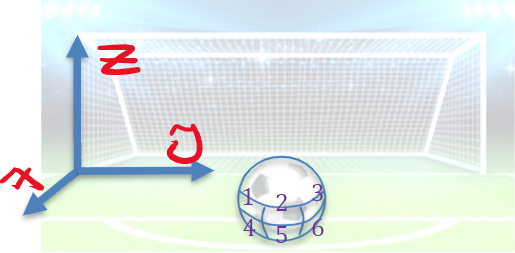

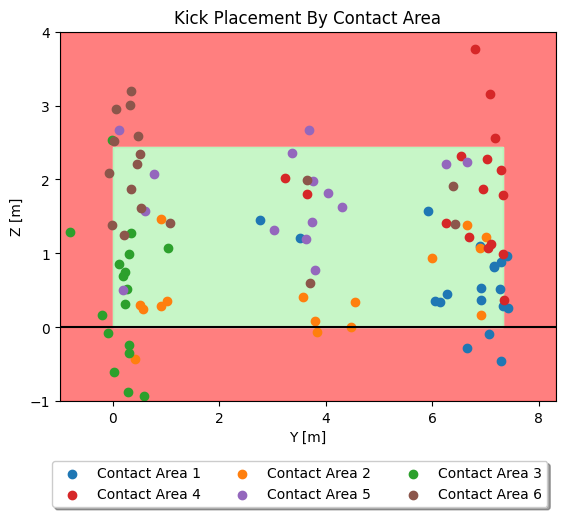

In [54]:
# Plot all the kicks on a 2d plane
fig, ax = plt.subplots()
ax.add_patch(Rectangle((-1, -1), 9.32, 5, color="red", alpha=0.5))
ax.add_patch(Rectangle((0, 0), 7.32, 2.44, color="white", alpha=1))
ax.add_patch(Rectangle((0, 0), 7.32, 2.44, color="lightgreen", alpha=0.5))
ax.axhline(y=0, color='black', linestyle='-')
for area in Areas:
    ax.scatter(kicks[kicks['area'] == area]['y'],
                kicks[kicks['area'] == area]['z'],
                label=f'Contact Area {area}')
ax.set_xlim((-1, 8.32))
ax.set_ylim((-1, 4.00))
ax.set_xlabel('Y [m]')
ax.set_ylabel('Z [m]')
handles, labels = ax.get_legend_handles_labels()
order = [0, 3, 1, 4, 2, 5]
fig.legend([handles[i] for i in order], [labels[i] for i in order],
           loc='upper center', bbox_to_anchor=(0.5, 0),
           fancybox=True, shadow=True, ncol=3)
ax.set_title('Kick Placement By Contact Area')
plt.savefig('./out/kick_plot_by_contact_area.png')
plt.show()

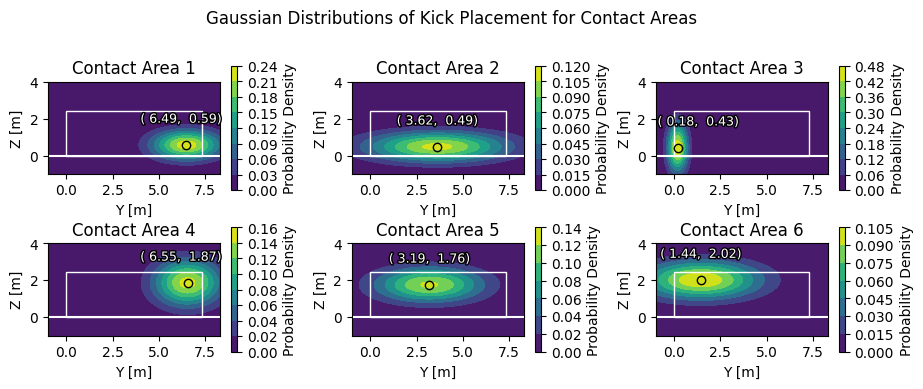

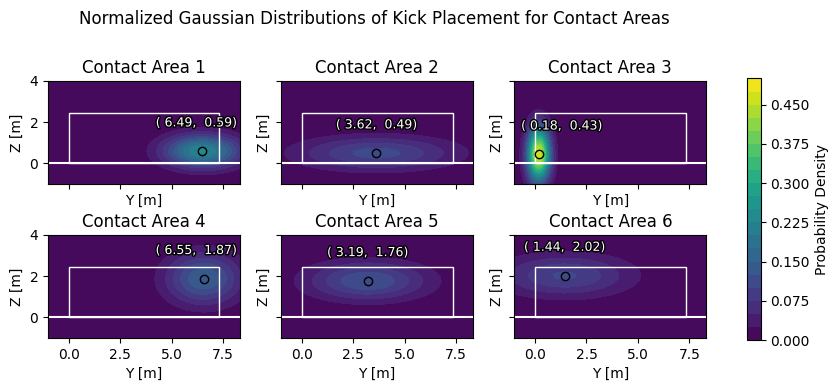

+--------------+--------+-------------+--------+-------------+
| Contact Area | Y Mean | Y Deviation | Z Mean | Z Deviation |
+--------------+--------+-------------+--------+-------------+
|      1       | 6.4937 |    1.6403   | 0.5852 |    0.2991   |
|      2       | 3.6229 |    6.7131   | 0.4883 |    0.3116   |
|      3       | 0.1790 |    0.1422   | 0.4347 |    0.8120   |
|      4       | 6.5535 |    1.5737   | 1.8657 |    0.7385   |
|      5       | 3.1949 |    3.9846   | 1.7620 |    0.4180   |
|      6       | 1.4352 |    4.7952   | 2.0183 |    0.4953   |
+--------------+--------+-------------+--------+-------------+


In [55]:
# Create a probability density function for the area of the kick
mean = np.array([kicks[kicks['area'] == area][['y', 'z']].mean() for area in Areas])
var = np.array([kicks[kicks['area'] == area][['y', 'z']].var() for area in Areas])

# Plot the probability density function for the area of the kick
rows, columns = (2, 3)
fig, axs = plt.subplots(rows, columns, sharex=False, sharey=False, figsize=(3*columns, 2*rows))
fig.suptitle(f'Gaussian Distributions of Kick Placement for Contact Areas')
fig.tight_layout(h_pad=-1, w_pad=3)
for i, area in enumerate(Areas):
    column = i % 3
    row = int((i - column) / 3)
    ax = axs[row, column]
    y = np.linspace(-1, 8.32, 100)
    z = np.linspace(-1, 4.00, 100)
    Y, Z = np.meshgrid(y, z)
    pos = np.empty(Y.shape + (2,))
    pos[:, :, 0] = Y
    pos[:, :, 1] = Z
    rv = stats.multivariate_normal(mean[i,:], np.diag(var[i,:]))
    ax.set_aspect('equal', adjustable='box')
    con = ax.contourf(Y, Z, rv.pdf(pos))
    ax.add_patch(Rectangle((0, 0), 7.32, 2.44, fill=False, edgecolor="white"))
    ax.axhline(y=0, color='white', linestyle='-')
    ax.plot(mean[i,0], mean[i,1], marker='o', fillstyle='none', color="black")
    ax.text(np.clip(mean[i,0],1.3,6.2), np.clip(mean[i,1]+1.2, 0.4, 3.3),
            f'({mean[i,0]: 0.2f}, {mean[i,1]: 0.2f})',
            fontsize=9, ha='center', color="white",
            path_effects=[pe.withStroke(linewidth=2, foreground="black")])
    ax.set_xlim((-1, 8.32))
    ax.set_ylim((-1, 4.00))
    ax.set_xlabel('Y [m]')
    ax.set_ylabel('Z [m]')
    fig.colorbar(con, ax=ax, shrink=0.85, label='Probability Density')
    ax.set_title(f'Contact Area {area}')
plt.savefig('./out/contact_area_probability_dist.png')
plt.show()

# Plot the normalized probability density function for the area of the kick
rows, columns = (2, 3)
fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(3*columns, 2*rows))
fig.suptitle(f'Normalized Gaussian Distributions of Kick Placement for Contact Areas', x=0.415)
fig.tight_layout(h_pad=-1, w_pad=1.5)
levels = np.linspace(0, 0.5, 21)
con = None
for i, area in enumerate(Areas):
    column = i % 3
    row = int((i - column) / 3)
    ax = axs[row, column]
    y = np.linspace(-1, 8.32, 100)
    z = np.linspace(-1, 4.00, 100)
    Y, Z = np.meshgrid(y, z)
    pos = np.empty(Y.shape + (2,))
    pos[:, :, 0] = Y
    pos[:, :, 1] = Z
    rv = stats.multivariate_normal(mean[i,:], np.diag(var[i,:]))
    ax.set_aspect('equal', adjustable='box')
    con = ax.contourf(Y, Z, rv.pdf(pos), levels)
    ax.add_patch(Rectangle((0, 0), 7.32, 2.44, fill=False, edgecolor="white"))
    ax.axhline(y=0, color='white', linestyle='-')
    ax.plot(mean[i,0], mean[i,1], marker='o', fillstyle='none', color="black")
    ax.text(np.clip(mean[i,0],1.3,6.2), np.clip(mean[i,1]+1.2, 0.4, 3.3),
            f'({mean[i,0]: 0.2f}, {mean[i,1]: 0.2f})',
            fontsize=9, ha='center', color="white",
            path_effects=[pe.withStroke(linewidth=2, foreground="black")])
    ax.set_xlim((-1, 8.32))
    ax.set_ylim((-1, 4.00))
    ax.set_xlabel('Y [m]')
    ax.set_ylabel('Z [m]')
    ax.set_title(f'Contact Area {area}')
fig.colorbar(con, ax=axs, shrink=0.85, label='Probability Density')
plt.savefig('./out/normalized_contact_area_probability_dist.png')
plt.show()

# Print the properties of the probability density for each contact area
headers = ['Contact Area', 'Y Mean', 'Y Deviation', 'Z Mean', 'Z Deviation']
rows = []
for i, area in enumerate(Areas):
    rows.append([area,
                 f'{mean[i,0]:0.4f}',
                 f'{var[i,0]:0.4f}',
                 f'{mean[i,1]:0.4f}',
                 f'{var[i,1]:0.4f}'])
table = PrettyTable(headers)
table.add_rows(rows)
with np.printoptions(formatter={'float': lambda x: "{0:+0.3f}".format(x)}):
    print(table)

## Weighted Sum Fusion

Weighted sum calcs:
$$
y_{ws} = \frac{\sum_{i=1}^{6} \frac{w_i}{\sigma_i^2} y_i}{\sum_{i=1}^{6} \frac{w_i}{\sigma_i^2}}
\\~\\
\sigma_{ws}^2 = \sum_{i=1}^{6} \left( \frac{\frac{w_i}{\sigma_i^2}}{\sum_{i=1}^6 \frac{w_i}{\sigma_i^2}} \right)^2 \sigma_i^2
$$

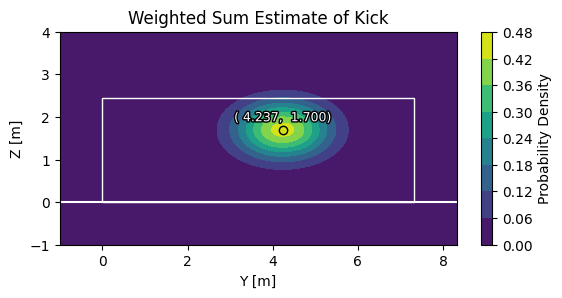

Expected Value of Kick: [4.23688124 1.70043275]
Expected Var of Kick: [0.59178403 0.21624351]


In [56]:
weight = np.array([0.02, 0.02, 0.02, 0.46, 0.46, 0.02])

# Calculate the expected value of the kick
expected_value = np.sum(mean * weight[:, None] / var , axis=0) / np.sum(weight[:, None] / var, axis=0)
expected_var = np.sum(((weight[:, None] / var) / (np.sum(weight[:, None] / var, axis=0)))**2 * var, axis=0)

# Plot the probability field
fig, ax = plt.subplots()
ax.set_title("Weighted Sum Estimate of Kick")
y = np.linspace(-1, 8.32, 100)
z = np.linspace(-1, 4.00, 100)
Y, Z = np.meshgrid(y, z)
pos = np.empty(Y.shape + (2,))
pos[:, :, 0] = Y
pos[:, :, 1] = Z
rv = stats.multivariate_normal(expected_value[:], np.diag(expected_var[:]))
con = ax.contourf(Y, Z, rv.pdf(pos))
ax.set_aspect('equal', adjustable='box')
ax.add_patch(Rectangle((0, 0), 7.32, 2.44, fill=False, edgecolor="white"))
ax.axhline(y=0, color='white', linestyle='-')
ax.plot(expected_value[0], expected_value[1],
        marker='o', fillstyle='none', color="black")
ax.text(expected_value[0], expected_value[1]+0.2,
        f'({expected_value[0]: 0.3f}, {expected_value[1]: 0.3f})',
        fontsize=9, ha='center', color="white",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")])
ax.set_xlim((-1, 8.32))
ax.set_ylim((-1, 4.00))
ax.set_xlabel('Y [m]')
ax.set_ylabel('Z [m]')
fig.colorbar(con, ax=ax, shrink=0.575, label='Probability Density')
plt.savefig('./out/weighted_sum_probability_dist.png')
plt.show()

# Output the values
print(f'Expected Value of Kick: {expected_value}')
print(f'Expected Var of Kick: {expected_var}')